In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, BatchNormalization,Dropout, Conv2D,LeakyReLU, GlobalAveragePooling2D,InputLayer

In [7]:
from ultralytics import YOLO
import cv2

# --- Load YOLO model once outside the function ---
yolo_model = YOLO(r"C:\Users\Dell\Desktop\yolo_models\runs\detect\train4\weights\best.pt")

def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()

    # --- Run YOLO prediction on the input image ---
    results = yolo_model.predict(source=img, conf=0.25, save=False, verbose=False)

    # --- Collect bounding boxes from YOLO output ---
    plate_rect = []  
    for r in results:
        for box in r.boxes.xyxy:  # xyxy for this type of format: [x1, y1, x2, y2] 
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            w, h = x2 - x1, y2 - y1
            plate_rect.append((x1, y1, w, h))

    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 2)

    if text != '':
        plate_img = cv2.putText(plate_img, text, (x - w//2, y - h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Dell\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


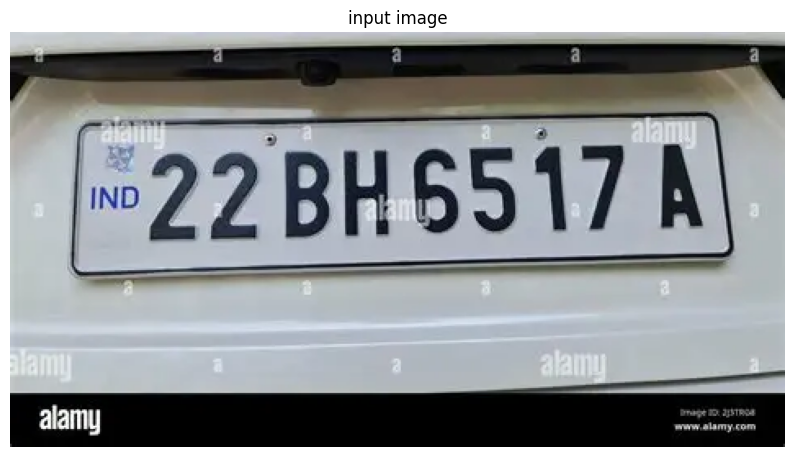

In [8]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread(r"C:\Users\Dell\Desktop\yolo_models\Prediction_images\image.png")
display(img, 'input image')

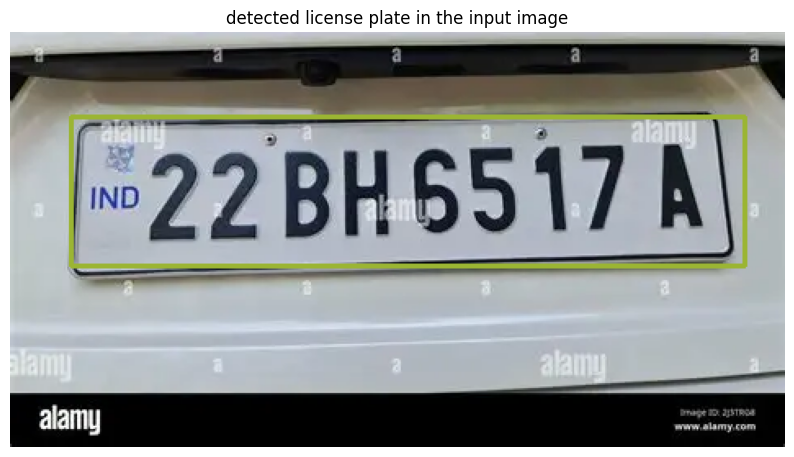

In [9]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

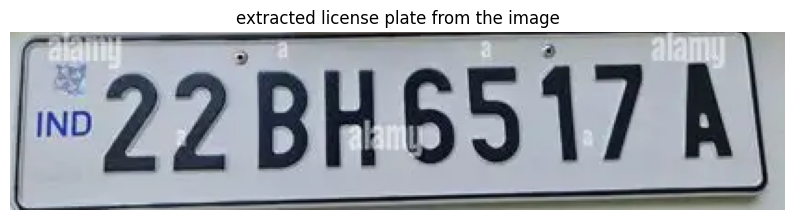

In [10]:
display(plate, 'extracted license plate from the image')

In [11]:

# Match contours to license plate or character template
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 15 contours for characters
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)  # stores the x coordinate of the character's contour

            # extracting each character using the enclosing rectangle's coordinates
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            
            # FIXED: Resize directly to 28x28 to match model input
            char = cv2.resize(char, (28, 28))
            
            cv2.rectangle(ii, (intX, intY), (intWidth+intX, intY+intHeight), (50, 21, 200), 2)
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            
            # FIXED: Convert grayscale to RGB (3 channels) to match model
            char = cv2.cvtColor(char, cv2.COLOR_GRAY2RGB)
            
            img_res.append(char)  # List that stores the character's image (unsorted)
    
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.imshow(ii, cmap='gray')
    plt.show()
    
    # arbitrary function that stores sorted list of character indices
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [12]:
# Find characters in the resulting images
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                  LP_WIDTH/2,
                  LP_HEIGHT/10,
                  2*LP_HEIGHT/3]
    
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

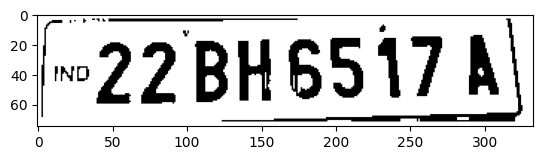

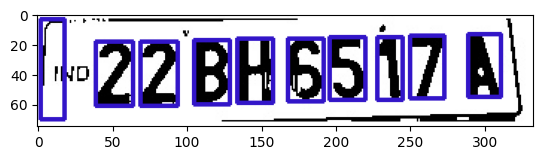

In [13]:
# Let's see the segmented characters
char = segment_characters(plate)

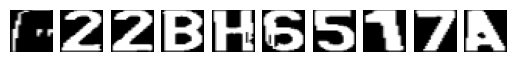

In [14]:
for i in range(len(char)):
    plt.subplot(1, len(char), i + 1)
    plt.imshow(char[i],cmap='gray')
    plt.axis('off')

(28, 28, 3)


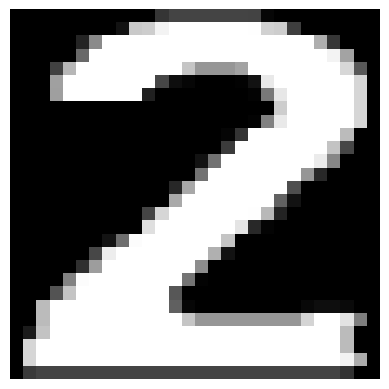

In [15]:
img = char[1].astype("uint8")
img=cv2.resize(img,(28,28))
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Model for characters

# we have the run the augmentation code(below code) only once at a time

In [16]:
import os
import shutil
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ----------------------------
# SOURCE DIRECTORIES
# ----------------------------
train_src = r"C:\Users\Dell\Desktop\yolo_models\data\data\train"
val_src   = r"C:\Users\Dell\Desktop\yolo_models\data\data\val"

# ----------------------------
# DESTINATION DIRECTORIES
# ----------------------------
base_dst  = r"C:\Users\Dell\Desktop\yolo_models\augmented_data"
train_dst = os.path.join(base_dst, "train")
val_dst   = os.path.join(base_dst, "val")

# recreate folders
if os.path.exists(base_dst):
    shutil.rmtree(base_dst)

os.makedirs(train_dst, exist_ok=True)
os.makedirs(val_dst, exist_ok=True)

# ----------------------------
# AUGMENTOR (only mild realistic transformations)
# ----------------------------
augmentor = ImageDataGenerator(
    rotation_range=12,             # only -12° to +12°
    width_shift_range=0.10,       # slight left/right shift
    height_shift_range=0.10,      # slight up/down shift
    zoom_range=0.10,              # small zoom
    shear_range=8,                # mild shear
)

# Number of augmented images per original image
AUG_PER_IMAGE = 7

# ----------------------------
# 1. AUGMENT TRAIN IMAGES
# ----------------------------
print("[INFO] Augmenting train images realistically...")

for class_name in os.listdir(train_src):
    src_class_dir = os.path.join(train_src, class_name)
    dst_class_dir = os.path.join(train_dst, class_name)

    if not os.path.isdir(src_class_dir):
        continue

    os.makedirs(dst_class_dir, exist_ok=True)
    print(f"[INFO] Processing class: {class_name}")

    for img_name in os.listdir(src_class_dir):

        if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        img_path = os.path.join(src_class_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Convert to array
        img_arr = np.array(img)
        img_arr = img_arr.reshape((1,) + img_arr.shape)

        # Save original first
        img.save(os.path.join(dst_class_dir, img_name))

        # Generate AUG_PER_IMAGE augmentations
        counter = 0
        for batch in augmentor.flow(
            img_arr,
            batch_size=1,
            save_to_dir=dst_class_dir,
            save_format="png"
        ):
            counter += 1
            if counter >= AUG_PER_IMAGE:
                break

# ----------------------------
# 2. COPY VAL IMAGES (NO AUGMENTATION)
# ----------------------------
print("[INFO] Copying validation images...")

for class_name in os.listdir(val_src):
    src_class_dir = os.path.join(val_src, class_name)
    dst_class_dir = os.path.join(val_dst, class_name)

    if not os.path.isdir(src_class_dir):
        continue

    os.makedirs(dst_class_dir, exist_ok=True)

    for img_name in os.listdir(src_class_dir):
        src = os.path.join(src_class_dir, img_name)
        dst = os.path.join(dst_class_dir, img_name)
        shutil.copy2(src, dst)

print("[INFO] DONE! Augmented dataset available at:", base_dst)


[INFO] Augmenting train images realistically...
[INFO] Processing class: class_0
[INFO] Processing class: class_1
[INFO] Processing class: class_2
[INFO] Processing class: class_3
[INFO] Processing class: class_4
[INFO] Processing class: class_5
[INFO] Processing class: class_6
[INFO] Processing class: class_7
[INFO] Processing class: class_8
[INFO] Processing class: class_9
[INFO] Processing class: class_A
[INFO] Processing class: class_B
[INFO] Processing class: class_C
[INFO] Processing class: class_D
[INFO] Processing class: class_E
[INFO] Processing class: class_F
[INFO] Processing class: class_G
[INFO] Processing class: class_H
[INFO] Processing class: class_I
[INFO] Processing class: class_J
[INFO] Processing class: class_K
[INFO] Processing class: class_L
[INFO] Processing class: class_M
[INFO] Processing class: class_N
[INFO] Processing class: class_O
[INFO] Processing class: class_P
[INFO] Processing class: class_Q
[INFO] Processing class: class_R
[INFO] Processing class: cla

## trial model to get the some estimate about parameters

In [17]:
path = r"C:\Users\Dell\Desktop\yolo_models\augmented_data"

train_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

train_generator = train_datagen.flow_from_directory(
    directory=path + "/train",   
    target_size=(28, 28),           
    class_mode='sparse'          
)

validation_generator = train_datagen.flow_from_directory(
    directory=path + "/val",     
    target_size=(28, 28),               
    class_mode='sparse'
)

model = Sequential()

# --- Input Layer ---
model.add(InputLayer(shape=(28, 28, 3)))

# --- Block 1 ---
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Block 2 ---
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Block 3 ---
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

# --- Global Average Pooling instead of Flatten ---
model.add(GlobalAveragePooling2D())

# --- Dense Layers ---
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

# --- Output Layer ---
model.add(Dense(36, activation='softmax'))

# --- Compile ---
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Found 6858 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [18]:
es = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=80,
                    verbose=1,
                    callbacks=[es])

c:\Users\Dell\anaconda3\envs\project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 80s 226ms/step - accuracy: 0.6171 - loss: 1.4531 - val_accuracy: 0.0972 - val_loss: 3.5525
Epoch 2/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 46s 213ms/step - accuracy: 0.9183 - loss: 0.3303 - val_accuracy: 0.9120 - val_loss: 0.2723
Epoch 3/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 48s 224ms/step - accuracy: 0.9503 - loss: 0.1804 - val_accuracy: 0.9861 - val_loss: 0.0408
Epoch 4/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 46s 212ms/step - accuracy: 0.9600 - loss: 0.1310 - val_accuracy: 0.9954 - val_loss: 0.0299
Epoch 5/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 47s 218ms/step - accuracy: 0.9654 - loss: 0.1050 - val_accuracy: 0.9954 - val_loss: 0.0272
Epoch 6/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.9698 - loss: 0.0872 - val_accuracy: 0.9722 - val_loss: 0.0529
Epoch 7/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 46s 213ms/step - accuracy: 0.9701 - loss: 0.0777 - val_accuracy: 0.9861 - val_loss: 0.0274
Epoch 8/80
215/215 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.9723 - loss: 0

In [19]:
model.save("cnn_model.h5")

### trained on kaggle hardware and loaded here

In [20]:
from keras.models import load_model
model = load_model('cnn_model.h5')   # this is our abouve trained model

## working for the prediction

In [21]:
# Predicting the output
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        # ch is already 28x28x3 from the corrected segmentation function
        img = ch / 255.0  # normalize
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_pred = model.predict(img, verbose=0)
        y_index = np.argmax(y_pred, axis=1)[0]  # get class index with highest probability
        
        character = dic[y_index]
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

T22BH6517A


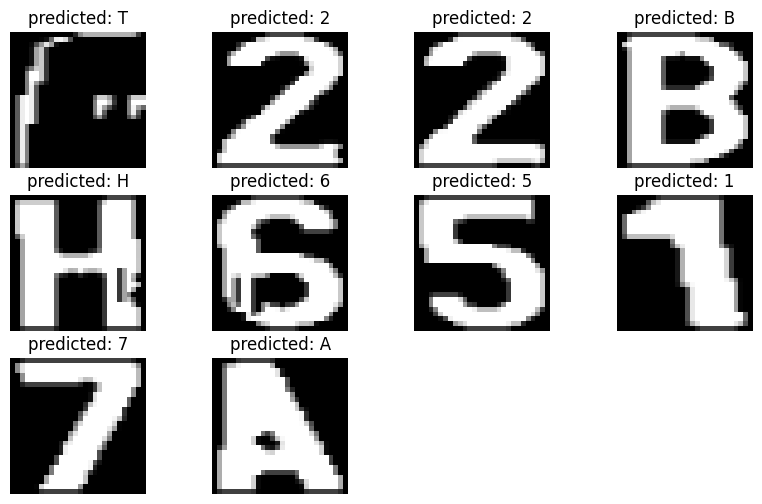

In [22]:
plt.figure(figsize=(10, 6))
for i, ch in enumerate(char):
    # ch is already 28x28x3 RGB
    plt.subplot(3, 4, i+1)
    plt.imshow(ch.astype('uint8'))  # display as RGB, not grayscale
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

# just for the running purpose exactly same as above

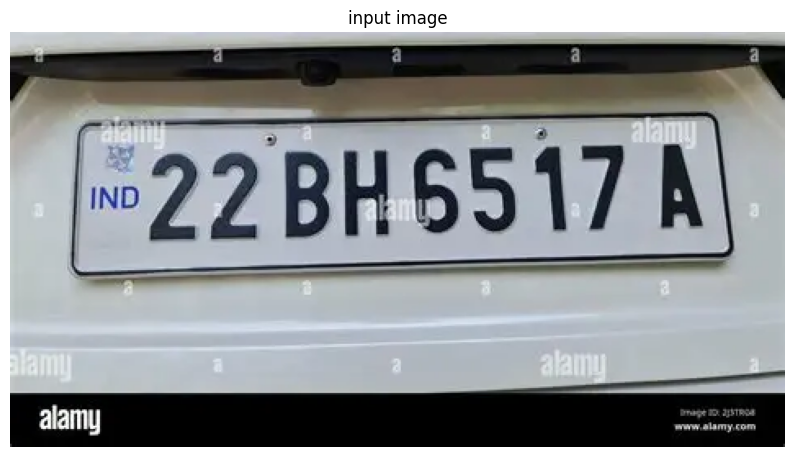

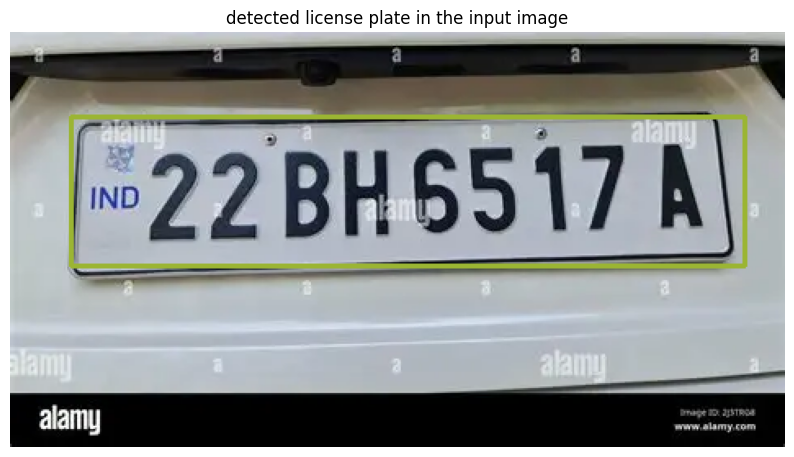

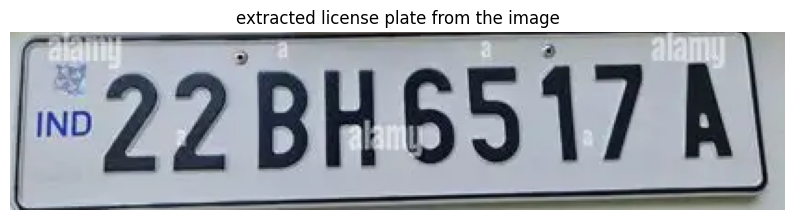

In [23]:
from ultralytics import YOLO
import cv2

# --- Load YOLO model once outside the function ---
yolo_model = YOLO(r"C:\Users\Dell\Desktop\yolo_models\runs\detect\train4\weights\best.pt")

def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()

    # --- Run YOLO prediction on the input image ---
    results = yolo_model.predict(source=img, conf=0.25, save=False, verbose=False)

    # --- Collect bounding boxes from YOLO output ---
    plate_rect = []  
    for r in results:
        for box in r.boxes.xyxy:  # xyxy for this type of format: [x1, y1, x2, y2] 
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            w, h = x2 - x1, y2 - y1
            plate_rect.append((x1, y1, w, h))

    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 2)

    if text != '':
        plate_img = cv2.putText(plate_img, text, (x - w//2, y - h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate

# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread(r'C:\Users\Dell\Desktop\yolo_models\Prediction_images\image.png')
display(img, 'input image')

# Getting plate prom the processed image
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

display(plate, 'extracted license plate from the image')



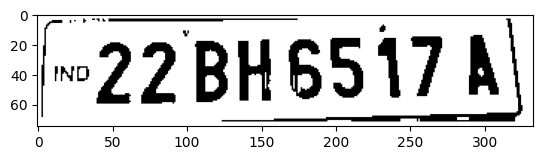

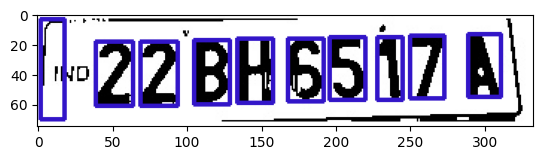

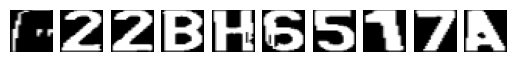

In [24]:

# Match contours to license plate or character template
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 15 contours for characters
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    
    for cntr in cntrs:
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)  # stores the x coordinate of the character's contour

            # extracting each character using the enclosing rectangle's coordinates
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            
            # FIXED: Resize directly to 28x28 to match model input
            char = cv2.resize(char, (28, 28))
            
            cv2.rectangle(ii, (intX, intY), (intWidth+intX, intY+intHeight), (50, 21, 200), 2)
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            
            # FIXED: Convert grayscale to RGB (3 channels) to match model
            char = cv2.cvtColor(char, cv2.COLOR_GRAY2RGB)
            
            img_res.append(char)  # List that stores the character's image (unsorted)
    
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.imshow(ii, cmap='gray')
    plt.show()
    
    # arbitrary function that stores sorted list of character indices
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


# Find characters in the resulting images
def segment_characters(image):
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3, 3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3, 3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                  LP_WIDTH/2,
                  LP_HEIGHT/10,
                  2*LP_HEIGHT/3]
    
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


# Let's see the segmented characters
char = segment_characters(plate)

for i in range(len(char)):
    plt.subplot(1, len(char), i + 1)
    plt.imshow(char[i],cmap='gray')
    plt.axis('off')

T22BH6517A


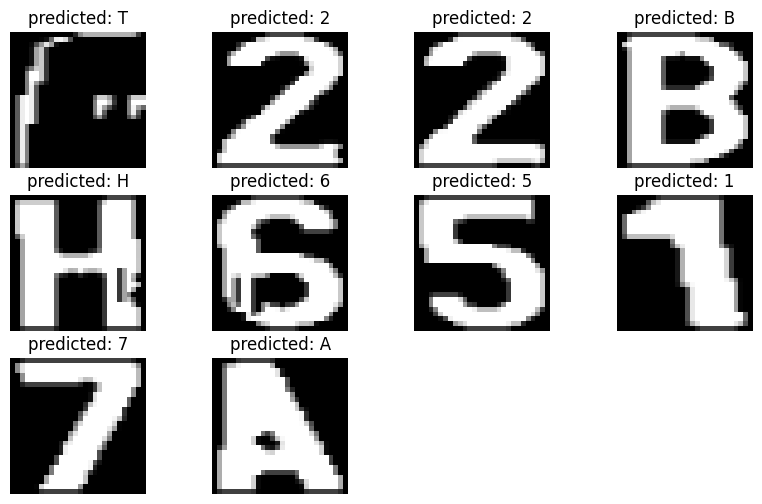

In [25]:
from keras.models import load_model
model = load_model('cnn_model.h5')

# Predicting the output
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        # ch is already 28x28x3 from the corrected segmentation function
        img = ch / 255.0  # normalize
        img = img.reshape(1, 28, 28, 3)  # preparing image for the model
        y_pred = model.predict(img, verbose=0)
        y_index = np.argmax(y_pred, axis=1)[0]  # get class index with highest probability
        
        character = dic[y_index]
        output.append(character)
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

plt.figure(figsize=(10, 6))
for i, ch in enumerate(char):
    # ch is already 28x28x3 RGB
    plt.subplot(3, 4, i+1)
    plt.imshow(ch.astype('uint8'))  # display as RGB, not grayscale
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()
